In [40]:
import time 
import sys 
import os

import gymnasium as gym
from gymnasium.envs.toy_text import blackjack

from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# BASE PYTHON IMPORTS
import random
from collections import deque, namedtuple
from itertools import count
from pathlib import Path

In [2]:
def new_usable_ace(hand):
    return int(1 in hand and sum(hand) + 10 <= 21)
    
blackjack.usable_ace = new_usable_ace

GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

## Setting up the Blackjack Env

In [6]:
env = gym.make('Blackjack-v1')
env.reset()

((11, 10, 0), {})

In [7]:
print(f'Action space: {env.action_space}. \n\n=> (1 = Hit, 0 = Bust)\n') 
print('-----------------------------------------------\n')
print(f'Observation space: {env.observation_space} \n\n=> (Player hand sum, Dealer card, Usable ace)')


Action space: Discrete(2). 

=> (1 = Hit, 0 = Bust)

-----------------------------------------------

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2)) 

=> (Player hand sum, Dealer card, Usable ace)


In [9]:
print("Observation Space:")
print('=> ', env.step(0))
# Observation, Reward, Done,truncated, info (empty)

Observation Space:
=>  ((11, 10, 0), -1.0, True, False, {})


## Random Actions Result

In [78]:
num_rounds = 10000 
num_samples = 10 

average_payouts = []
win = 0 
lose = 0
draw = 0
start_time = time.time()
for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action 
        observation, reward, terminated, truncated, _ = env.step(action)
        total_payout += reward
        done = terminated or truncated
        if done:
            if reward == 1:
                win += 1
            elif reward == -1: 
                lose += 1 
            elif reward == 0:
                draw += 1 
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

print(f'Wins: {win/(win+lose+draw)*100:0.2f}%, Lose: {lose/(win+lose+draw)*100:0.2f}%, Draw: {draw/(win+lose+draw)*100:0.2f}%') 
print ("Average reward after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))
print(f"Average per round is {sum(average_payouts) / num_samples / num_rounds:0.3f}")

Wins: 28.34%, Lose: 67.60%, Draw: 4.06%
Average reward after 10000 rounds is -3926.0
Average per round is -0.393


## Plot Helper Functions
First two from MatPlotLib documentation example

In [23]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


# Displays the action taken for each possible state
def show_action_tables(hard_preds, soft_preds, title_hard='', title_soft='', fig_title=''):
    dealer_states = list(range(2, 12))
    player_hard_states = list(range(4, 22))
    player_soft_states = ['A, 2', 'A, 3', 'A, 4', 'A, 5', 'A, 6', 'A, 7', 'A, 8', 'A, 9']

    hard_hand_actions = hard_preds.int().numpy().reshape((18, 10))
    soft_hand_actions = soft_preds.int().numpy().reshape((8, 10))

    fig, ax = plt.subplots(1, 2, figsize=(18, 10))
    # Hard table
    ax[0].title.set_text(title_hard)
    im = heatmap(hard_hand_actions, player_hard_states, dealer_states, ax=ax[0],
                       cmap="Wistia")
    annotate_heatmap(im, valfmt="{x}")

    # Soft table
    im = heatmap(soft_hand_actions, player_soft_states, dealer_states, ax=ax[1],
                 cmap="Wistia")
    annotate_heatmap(im, valfmt="{x}")
    ax[1].title.set_text(title_soft)

    if fig_title:
        fig.suptitle(fig_title)

    fig.tight_layout()
    plt.show()

## Create the ideal solution

In [24]:
def create_ideal_solution():
    # Dealer always stands on 17. If player has Ace, it will show the highest possible hand value
    # X hard totals
    player_states = 18
    dealer_states = 10

    # All hard hand inputs
    # Player 4 - 21, Dealer 2 - 11
    x_hard_hand = np.zeros((player_states * dealer_states, 3))
    for i in range(player_states * dealer_states):
        dealer_card = np.floor(i / player_states)
        player_card = i % player_states
        x_hard_hand[i] = (player_card + 4, dealer_card + 2, 0)

    # Create ideal hard hand actions
    y_hard_hand = np.ones((player_states, dealer_states))
    for player_total in range(9, player_states + 4):
        for dealer_total in range(2, dealer_states + 2):
            player_idx = player_total - 4
            dealer_idx = dealer_total - 2

            # Times to stand
            if player_total >= 17:
                y_hard_hand[player_idx][dealer_idx] = 0

            if 13 <= player_total <= 16:
                if dealer_total <= 6:
                    y_hard_hand[player_idx][dealer_idx] = 0

            if player_total == 12 and 4 <= dealer_total <= 6:
                y_hard_hand[player_idx][dealer_idx] = 0

    # X soft totals
    player_states = 8
    dealer_states = 10

    # All soft hand inputs
    # Player 13 - 20, Dealer 2 - 11
    x_soft_hand = np.zeros((player_states * dealer_states, 3))
    for i in range(player_states * dealer_states):
        dealer_card = np.floor(i / player_states)
        player_card = i % player_states
        x_soft_hand[i] = (player_card + 13, dealer_card + 2, 1)

    # Create ideal soft hand actions
    y_soft_hand = np.ones((player_states, dealer_states))
    for player_total in range(18, player_states + 13):
        for dealer_total in range(2, dealer_states + 2):
            player_idx = player_total - 13
            dealer_idx = dealer_total - 2

            # Times to stand
            if player_total >= 19:
                y_soft_hand[player_idx][dealer_idx] = 0

            if player_total == 18:
                if dealer_total <= 8:
                    y_soft_hand[player_idx][dealer_idx] = 0

    x_soft_hand = torch.from_numpy(x_soft_hand).float() 
    x_hard_hand = torch.from_numpy(x_hard_hand).float()
    y_soft_hand = torch.from_numpy(y_soft_hand.reshape((-1, 1))).float()
    y_hard_hand = torch.from_numpy(y_hard_hand.reshape((-1, 1))).float()

    return x_soft_hand, x_hard_hand, y_soft_hand, y_hard_hand 

In [25]:
IDEAL_SOLUTION = create_ideal_solution()

## Creating the Model

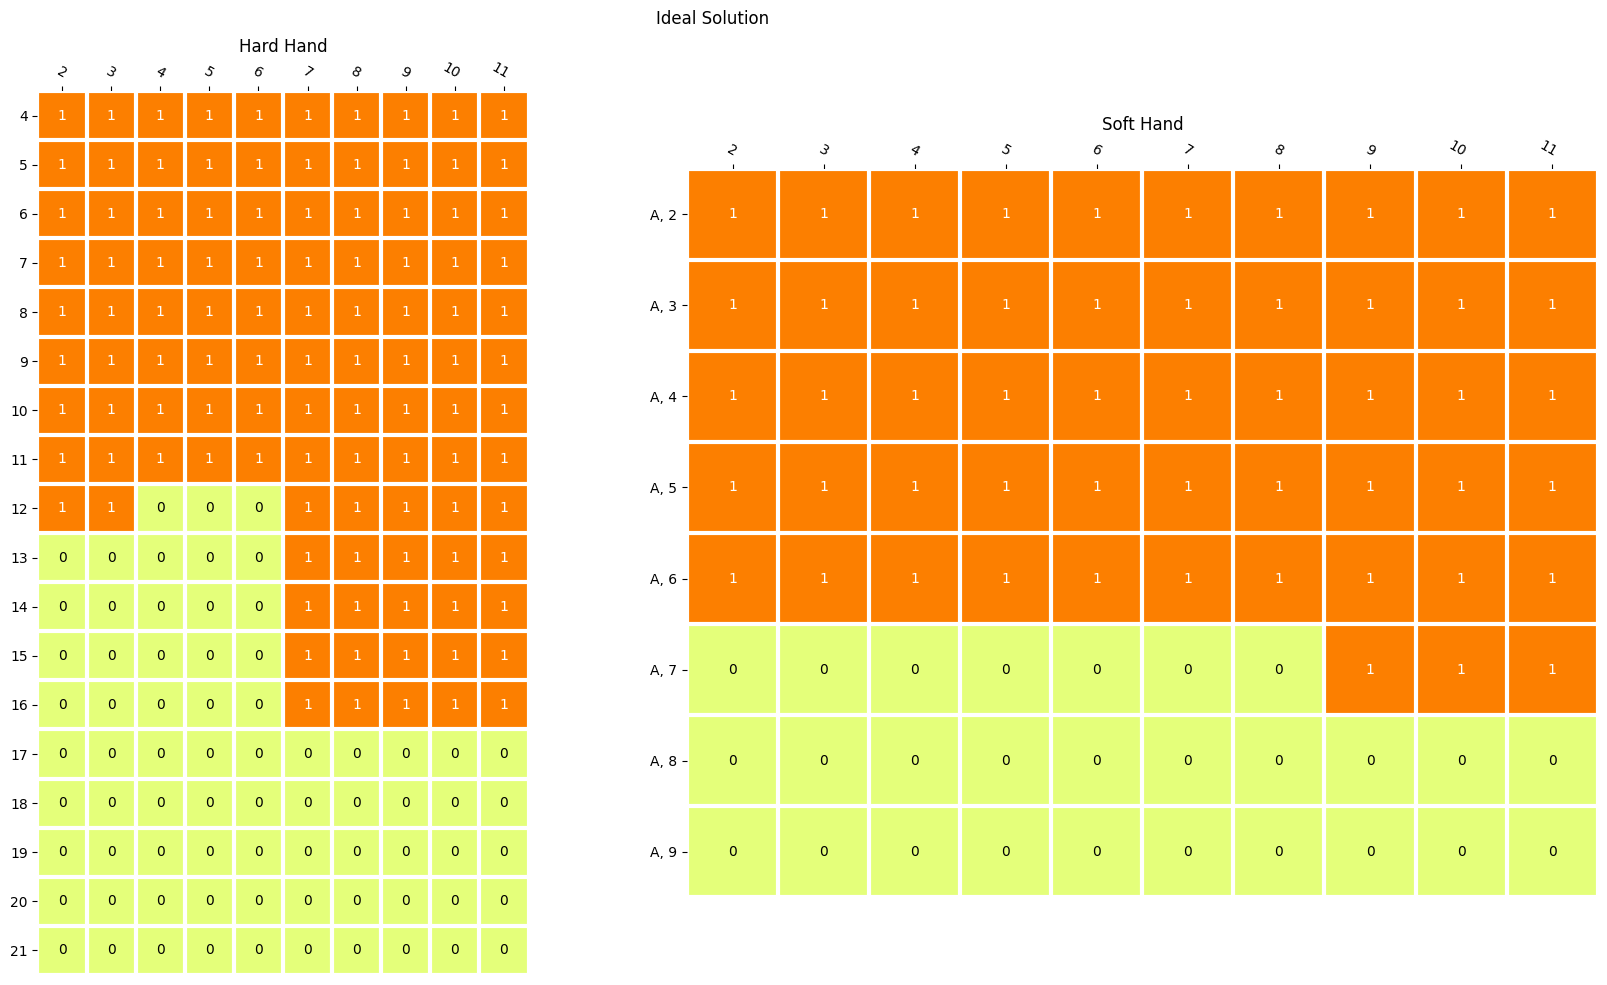

In [26]:
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, 24)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(24, number_of_actions)

        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
            self.fc2 = nn.utils.weight_norm(self.fc2)
            self.fc3 = nn.utils.weight_norm(self.fc3)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)

        return out   

show_action_tables(DQNetwork(IDEAL_SOLUTION).y_hard_hand, 
                   DQNetwork(IDEAL_SOLUTION).y_soft_hand,
                   title_hard='Hard Hand', 
                   title_soft='Soft Hand', 
                   fig_title="Ideal Solution")

## Implement experience memory

Memory of previous actions to be fed into the network as "experience replay"

Class based on: 
https://github.com/nalkpas/CS230-2018-Project/blob/master/blackjack_DQN.py


In [29]:
# Transition = namedtuple(
#     'Transition',
#     ('state', 'action', 'next_state', 'reward'，'done')
#     )


# class ReplayMemory(object):
#     """
#     A class to store gym transitions
#     """
#     def __init__(self, capacity):
#         self.memory = deque([], maxlen=capacity)

#     def push(self, *args):
#         """Save a transition"""
#         self.memory.append(Transition(*args))

#     def sample(self, batch_size):
#         return random.sample(self.memory, batch_size)

#     def __len__(self):
#         return len(self.memory)

class Memory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, cur_state, action, next_state, reward, done):

        cur_state_t = torch.Tensor(cur_state)
        action_t = torch.Tensor([action])
        next_state_t = torch.Tensor(next_state)
        rewart_t = torch.Tensor([reward])
        done_t = torch.Tensor([done])

        state_trans = [cur_state_t, action_t, rewart_t, next_state_t, done_t]

        if len(self.memory) < self.capacity:
            self.memory.append(state_trans)
        else:
            self.memory[self.position] = state_trans
            self.position = (self.position + 1) % self.capacity

    def sample(self, batchsize=10):
        minibatch = random.sample(self.memory, batchsize)
        state_batch = torch.stack(tuple(sample[0] for sample in minibatch))
        action_batch = torch.stack(tuple(sample[1] for sample in minibatch))
        reward_batch = torch.stack(tuple(sample[2] for sample in minibatch))
        state_1_batch = torch.stack(tuple(sample[3] for sample in minibatch))
        done_batch = torch.stack(tuple(sample[4] for sample in minibatch))

        return state_batch, action_batch, reward_batch, state_1_batch, done_batch

    def __len__(self):
        return len(self.memory)

## Training Functions

In [45]:
def train_net(model, optimizer, memory, loss_func, n_steps, n_episodes, save_path, loggers, exp_epsilon_decay=False):
    training_loss_logger, hard_accuracy_logger, soft_accuracy_logger = loggers

    epsilon_decrements = []
    if exp_epsilon_decay:
        epsilon_decrements = [EPSILON_INITIAL]
        found_eps_min = False
        for i in range(TOTAL_EPISODES):
            if epsilon_decrements[i] > EPSILON_FINAL:
                epsilon_decrements.append(epsilon_decrements[i] * EPSILON_DECAY)
            elif not found_eps_min:
                epsilon_decrements.append(epsilon_decrements[i])
                print(f'Minimum Epsilon reached in {i} episodes')
                found_eps_min = True
            else:
                epsilon_decrements.append(epsilon_decrements[i])
   
    else:
        epsilon_decrements = np.linspace(EPSILON_INITIAL, EPSILON_FINAL, n_episodes+1)


    start_time = time.time()
    for episode_idx in range(model.current_episode, model.current_episode + n_episodes + 1):
        # Decrement epsilon
        epsilon = epsilon_decrements[episode_idx - model.current_episode] 

        # Call the training function
        training_loss_logger = train(model, optimizer, memory, loss_func,
                                     epsilon, n_steps, training_loss_logger)

        # Log model accuracy for episode
        hard_accuracy, soft_accuracy = evaluate(model)

        hard_accuracy_logger.append(hard_accuracy)
        soft_accuracy_logger.append(soft_accuracy)
        loggers = training_loss_logger, hard_accuracy_logger, soft_accuracy_logger

        # Save a checkpoint every 2000 episodes
        if episode_idx % 2000 == 0:
            if episode_idx != 0:
                clear_output()
            evaluate(model, display_result=True, episode_idx=episode_idx)
            torch.save({
                'episode_idx': episode_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loggers': loggers,
                'hyperparams_dict': hyperparams_dict,
                'episode_idx': episode_idx
            }, save_path)
            print('Model Saved')

        if episode_idx % 200 == 0:
            print(f'| Episode: {episode_idx:02} | Train Loss: {training_loss_logger[episode_idx-1]:0.2f} '
                  f'| Hard Acc: {hard_accuracy:0.2f} | Soft Acc: {soft_accuracy:0.2f} |')

    end_time = time.time()
    print("Training time %.2f seconds" % (end_time - start_time))

    return loggers

In [54]:
def train(model, optimizer, memory, loss_func, epsilon, n_steps, loss_logger):
    cur_state,_ = env.reset()
    with torch.no_grad():
        # uses epsilon greedy to explore
        for step_i in range(n_steps):
            print()
            cur_state_t = torch.Tensor(cur_state).to(device)
            action = get_action(model, cur_state_t, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            is_done = terminated or truncated
            memory.push(cur_state, action, next_state, reward, is_done)
            if is_done:
                cur_state,_ = env.reset() 
            else:
                cur_state = next_state
    if len(memory) > MINIBATCH_SIZE:
        update_network(model, optimizer, memory, loss_func, loss_logger)

    return loss_logger

In [63]:
def evaluate(model, display_result=False, episode_idx=0):
    model.eval()
    with torch.no_grad():
        x_hard_hand = model.x_hard_hand.to(device)  
        x_soft_hand = model.x_soft_hand.to(device)  


        y_pred_hard = model(x_hard_hand)
        y_pred_hard = torch.max(y_pred_hard, 1)[1].float().cpu()
        y_pred_hard = y_pred_hard.reshape((10, 18)).t().reshape((-1, 180)).squeeze()

        y_pred_soft = model(x_soft_hand).to('cuda')
        y_pred_soft = torch.max(y_pred_soft, 1)[1].float().cpu()
        y_pred_soft = y_pred_soft.reshape((10, 8)).t().reshape((-1, 80)).squeeze()

        y_hard = model.y_hard_hand.squeeze().cpu()
        y_soft = model.y_soft_hand.squeeze().cpu()

        correct_action_hard = torch.eq(y_hard, y_pred_hard)
        correct_action_soft = torch.eq(y_soft, y_pred_soft)

        correct_action_hard = correct_action_hard.reshape((18, 10))
        correct_action_soft = correct_action_soft.reshape((8, 10))

        fig_title = f'Episodes: {episode_idx}' if episode_idx > 0 else None

        if display_result:
            show_action_tables(y_pred_hard, y_pred_soft,
                               "Hard Hand Actions by Model", "Soft Hand Actions by Model", fig_title=fig_title)

        if correct_action_hard.sum().item() != 0:
            hard_hand_accuracy =  correct_action_hard.sum().item() / correct_action_hard.numel() * 100
        else:
            hard_hand_accuracy = 0
        if correct_action_soft.sum().item() != 0:
            soft_hand_accuracy = correct_action_soft.sum().item() / correct_action_soft.numel() * 100
        else:
            soft_hand_accuracy = 0

        return hard_hand_accuracy, soft_hand_accuracy

In [58]:
def get_action(model, cur_state, epsilon):

    if np.random.rand() < epsilon:
        return np.random.randint(0, NUMBER_OF_ACTIONS)
    else:
        predicted_action = model(cur_state)
        values, index = predicted_action.max(0)
        return index.item()


def update_network(model, optimizer, memory, loss_func, loss_logger):

    model.train()
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = memory.sample(MINIBATCH_SIZE)
    state_batch = state_batch.to(device)
    action_batch = action_batch.to(device)
    reward_batch = reward_batch.to(device)
    next_state_batch = next_state_batch.to(device)
    done_batch = done_batch.to(device)


    current_state_qs = model(state_batch)  # Shape = [batch_size, action_size]
    next_state_qs = model(next_state_batch)
    target_qs_list = []

    for i in range(MINIBATCH_SIZE):
        # If the Action didn't cause it to finish, the max q is given from the next q values * gamma discount
        if not done_batch[i]:
            max_future_q = torch.max(next_state_qs[i])
            new_q = reward_batch[i] + GAMMA * max_future_q
        # If final state reached, the max q of the action taken is the reward value received
        else:
            new_q = reward_batch[i]

        action_taken = int(action_batch[i].item())
        current_qs = current_state_qs[i].clone() 
        current_qs[action_taken] = new_q
        target_qs_list.append(current_qs)

    target_q_values = torch.stack(target_qs_list)

    optimizer.zero_grad()

    # Calculate Loss
    loss = loss_func(current_state_qs, target_q_values)
    loss_logger.append(loss.item())
    loss.backward()

    # Update Model
    optimizer.step()
    model.eval()

## Utility Functions

### Function to load Checkpointing

In [59]:
def load_model(model, save_dir, save_path, load_checkpoint=False, load_hyperparams=False):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
  #Load Checkpoint
    if load_checkpoint:
        #Check if checkpoint exists
        if os.path.isfile(save_path):
            #load Checkpoint
            check_point = torch.load(save_path)
            model.load_state_dict(check_point['model_state_dict'])
            model.optimizer.load_state_dict(check_point['optimizer_state_dict'])
            model.current_episode = check_point['episode_idx']
            model.loggers = check_point['loggers']
            print(f'Current Hard Accuracy: {model.loggers[1][model.current_episode]:0.2f}, '
                  f'Current Soft Accuracy: {model.loggers[2][model.current_episode]:0.2f}')
            print("Checkpoint loaded, starting from episode:", model.current_episode)
            return True
        
        else:
            print("Checkpoint Does not exist")
            return False

    elif load_hyperparams:
        check_point = torch.load(save_path)
        hyperparams_dict = check_point['hyperparams_dict']

        global NUMBER_OF_ACTIONS, NUMBER_OF_STATES, EPSILON_FINAL, EPSILON_FINAL, EPSILON_DECAY, GAMMA, \
               REPLAY_MEMORY_SIZE, MINIBATCH_SIZE, STEPS_PER_EPISODE, TOTAL_EPISODES, LEARNING_RATE
        NUMBER_OF_ACTIONS = hyperparams_dict['NUMBER_OF_ACTIONS']
        NUMBER_OF_STATES = hyperparams_dict['NUMBER_OF_STATES']
        EPSILON_FINAL = ['EPSILON_FINAL']
        EPSILON_DECAY = hyperparams_dict['EPSILON_DECAY']
        GAMMA = hyperparams_dict['GAMMA']
        REPLAY_MEMORY_SIZE = hyperparams_dict['REPLAY_MEMORY_SIZE']
        MINIBATCH_SIZE = hyperparams_dict['MINIBATCH_SIZE']
        STEPS_PER_EPISODE = hyperparams_dict['STEPS_PER_EPISODE']
        TOTAL_EPISODES = hyperparams_dict['TOTAL_EPISODES']
        LEARNING_RATE = hyperparams_dict['LEARNING_RATE']

        print('Hyperparams loaded from the checkpoint')
        return False

    else:
        print('No model loaded')
        return False

### Function to get model's resutls

In [49]:
def obtain_model_result(model, save_path):
    model.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    memory = Memory(REPLAY_MEMORY_SIZE)
    loss_func = nn.MSELoss()

    # Reset loggers to empty
    training_loss_logger = [0]
    hard_accuracy_logger = []
    soft_accuracy_logger = []
    model.loggers = training_loss_logger, hard_accuracy_logger, soft_accuracy_logger

    # Load a previous model
    load_checkpoint = True
    load_only_hyperparams = False
    checkpoint_loaded = load_model(model, save_dir, save_path, load_checkpoint, load_only_hyperparams)

    if not checkpoint_loaded:
        loggers = train_net(model, model.optimizer, memory, loss_func, STEPS_PER_EPISODE, TOTAL_EPISODES, save_path, model.loggers)
    
    return model.loggers

### Function for plotting results

In [50]:
def plot_results(results):
    loss_logger = results[0]
    hard_accuracy_logger = results[1]
    soft_accuracy_logger = results[2]


    plt.figure(figsize=(14, 7))
    x = np.linspace(0, TOTAL_EPISODES, len(hard_accuracy_logger))
    plt.plot(x, hard_accuracy_logger, c="r")
    plt.plot(x, soft_accuracy_logger, c="b")

    plt.legend(["Hard Hand Accuracy", "Soft Hand Accuracy"])
    plt.title("Accuracy per Episode")

    plt.show()


### Connect with Google Drive


In [51]:
ROOT = r"C:\Users\jasonluo\blackjack-poker-agent/"
sys.path.append(ROOT)
save_dir = ROOT + 'Models'

## Train the baseline model


### Hyperparametes

In [67]:
NUMBER_OF_ACTIONS = 2
NUMBER_OF_STATES = 3

EPSILON_INITIAL = 1
EPSILON_FINAL = 0.01
EPSILON_DECAY = 0.9 
GAMMA = 0.999  # discount factor

REPLAY_MEMORY_SIZE = 10000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 100_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}


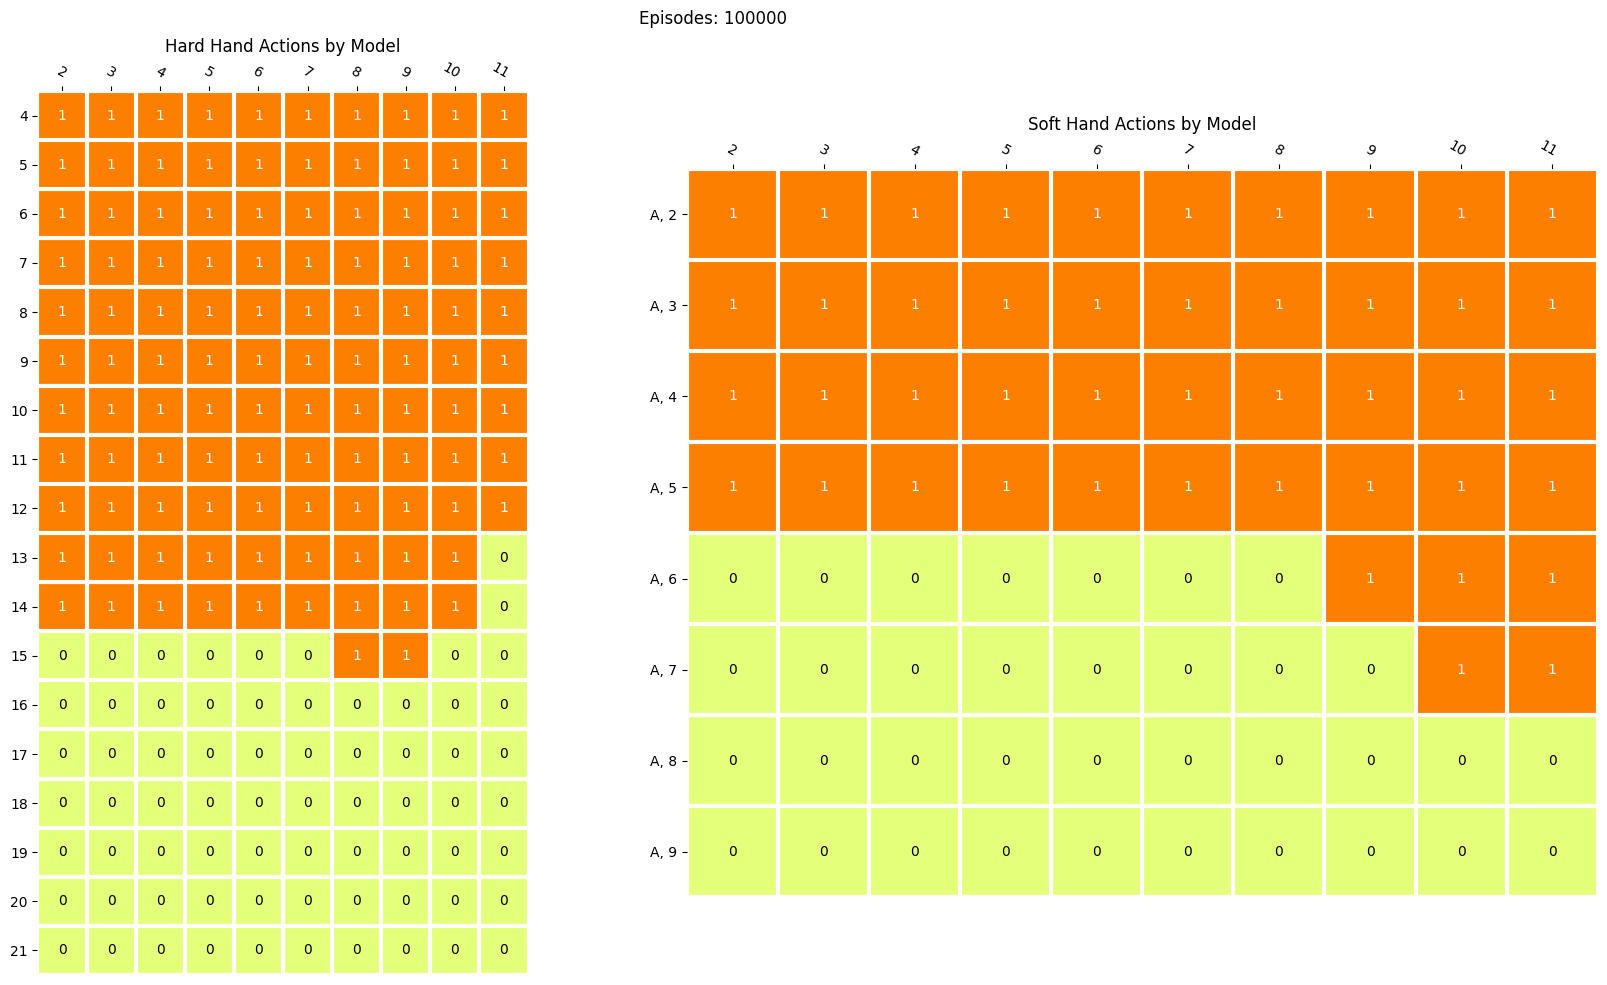

Model Saved
| Episode: 100000 | Train Loss: 0.23 | Hard Acc: 87.22 | Soft Acc: 90.00 |
Training time 7970.98 seconds


In [68]:
# Create the model
model = DQNetwork(IDEAL_SOLUTION, weight_norm=False).to(device) 

# Creat model file name
version = 1.2
model_name = f'Full_Model_Run_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

# Will train the model if it does not exist
loggers = obtain_model_result(model, save_path)

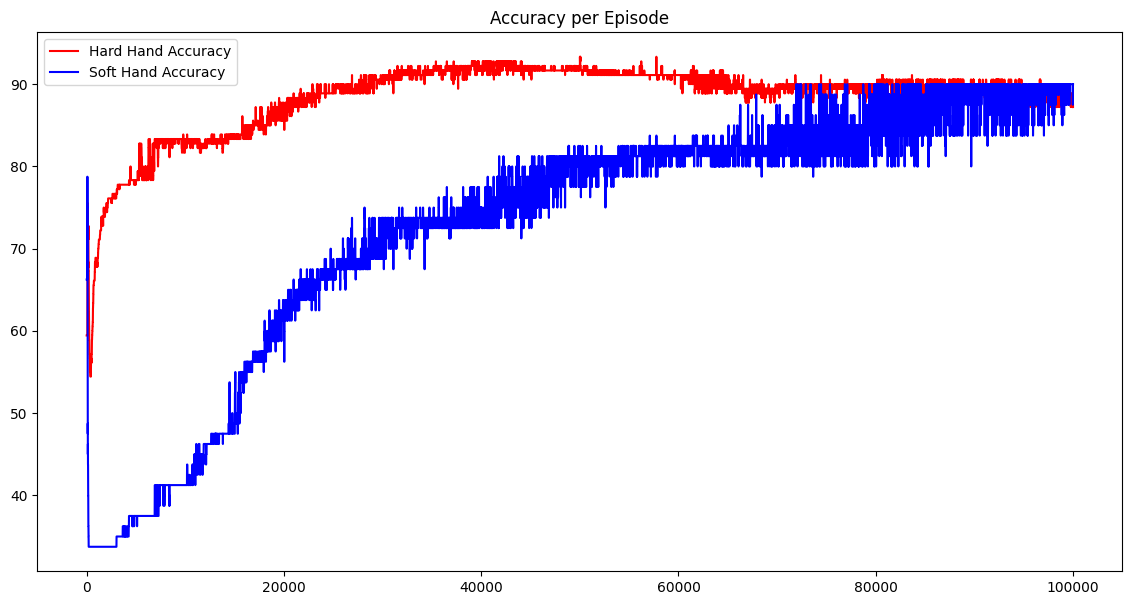

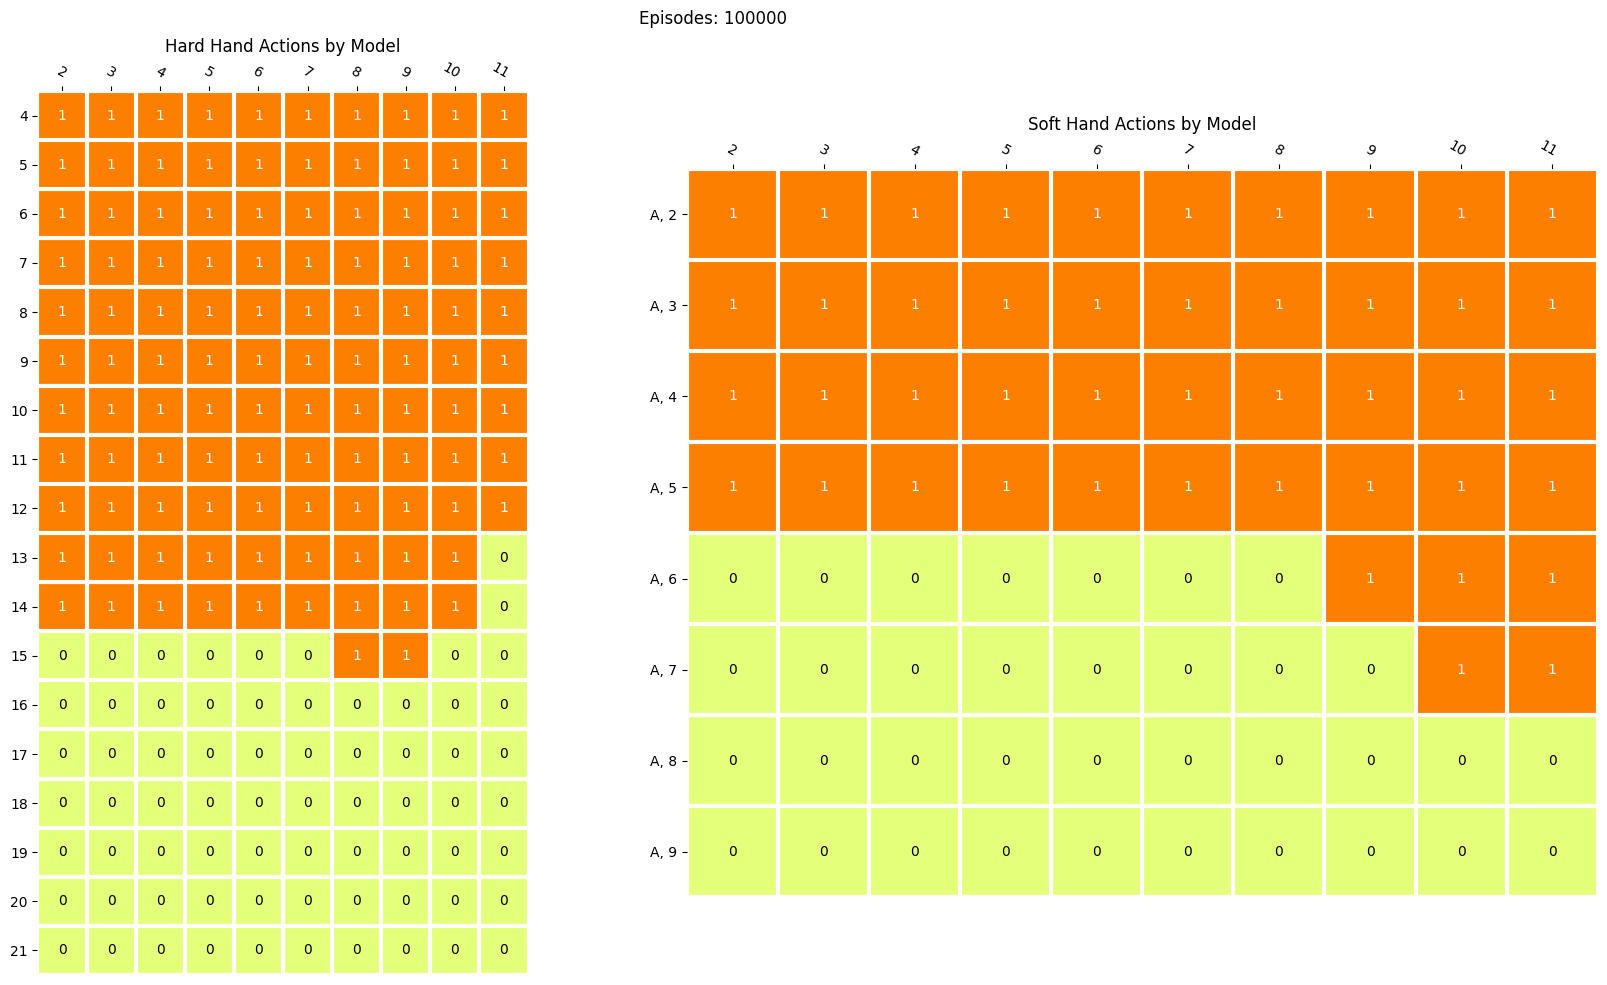

Hard Acc Final: 87.22, Soft Acc Final: 90.00


In [69]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

### Compare with random guessing

In [77]:
# For comparison to the random model at the start

num_rounds = 10000  # reward calculated over num_rounds
num_samples = 10  # num_rounds simulated over num_samples
average_reward = []

model.eval()
actions_taken = []
with torch.no_grad():
    win = 0 
    lose = 0
    draw = 0
    for sample in range(num_samples):
        round = 1    
        total_reward = 0  # to store total reward over 'num_rounds'
        cur_state, _ = env.reset()
        while round <= num_rounds:
            cur_state_t = torch.Tensor(cur_state).to(device)
            action = get_action(model, cur_state_t, 0)
            if round % 10 == 0:
                actions_taken.append(action)
            cur_state, reward, terminated,truncated, _ = env.step(action)
            is_done = terminated or truncated
            total_reward += reward
        
            if is_done:
                if reward == 1:
                    win += 1
                elif reward == -1: 
                    lose += 1 
                elif reward == 0:
                    draw += 1 
                cur_state,_ = env.reset()  # Environment deals new cards to player and dealer
                round += 1
        average_reward.append(total_reward)

print(f'Wins: {win/(win+lose+draw)*100:0.2f}%, Lose: {lose/(win+lose+draw)*100:0.2f}%, Draw: {draw/(win+lose+draw)*100:0.2f}%')
print(f"Average reward for {num_rounds} rounds is {sum(average_reward) / num_samples}\n" \
      f"Average per round is {sum(average_reward) / num_samples / num_rounds:0.3f}\n"
      f"Average per round for random is -0.4 ")

Wins: 42.71%, Lose: 48.51%, Draw: 8.78%
Average reward for 10000 rounds is -579.8
Average per round is -0.058
Average per round for random is -0.4 
